In [53]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from os.path import join as oj
import sys
sys.path.append('../vision_fit')
import data
import numpy as np
from copy import deepcopy
import pickle as pkl
from torch.optim.lr_scheduler import StepLR
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import models
from dim_reduction import *
%load_ext autoreload
%autoreload 2

# load some models             
modelm = models.MnistNet()        
convnet = models.LeNet()
linnet = models.LinearNet(4, 28*28, 256, 10)
model = linnet
model = model.cuda()

# load mnist
from params_vision import p
p.dset = 'mnist'
p.shuffle_labels = False
train_loader, test_loader = data.get_data_loaders(p)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get the full dsets

In [9]:
X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)

In [10]:
print(X_train.shape)

torch.Size([60000, 1, 28, 28])


tensor([[-0.0864, -0.0388,  0.0690, -0.0502,  0.0824,  0.0463, -0.0271,  0.0062,
          0.0332, -0.0827]], device='cuda:0', grad_fn=<AddmmBackward>)

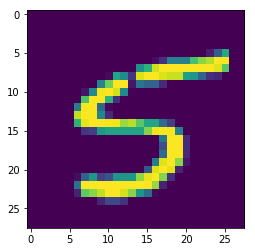

In [17]:
plt.imshow(X_train[1, 0].cpu().detach().numpy())
linnet(X_train[0])

In [ ]:
ex_nums = {}
i = 0
while(len(ex_nums) < 10):
    ex_nums[train_set.train_labels[i]] = i
    i += 1
exs = np.zeros((10, 28, 28))
for i in range(10):
    exs[i] = train_set.train_data[i]
train_set.train_data = torch.Tensor(exs)
train_set.train_labels = torch.Tensor(np.arange(0, 10)).long()

In [40]:
X_train, Y_train_onehot = data.get_XY(train_loader)

In [62]:
# get prototype images for each label (eventually support multiple reps)
# returns images (X) and labels (Y)
def get_ims_per_lab(X_train, Y_train_onehot):
    exs = np.zeros((10, 784))
    for i in range(10):
        idxs = Y_train_onehot[:, i] == 1
        exs[i] = X_train[idxs][0]
    return torch.Tensor(exs), range(10)
exs, labs = get_ims_per_lab(X_train, Y_train_onehot)

In [64]:
# set the final layer of the dnn to the activations of the exs
def set_final_lay_lin(linnet, exs):
    acts = linnet.features(exs)
    linnet.fc[-1].weight = torch.nn.Parameter(acts)
# exs = exs.cuda()
set_final_lay_lin(linnet, exs)    

In [65]:
X_train.shape

(60000, 784)